# Projet Fil Rouge 2024 : Reconnaissance de commandes audio

**Noms : GAY & GRIS**

**Prénoms : Tristan & Clément**

Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des commandes pour les drones).

Ces séances se décomposent en ces parties :
- Partie I : Prétraitement des données
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude

<div class="alert alert-block alert-warning">
    
**Introduction**

Le projet "Projet Fil Rouge" a pour objectif de mettre en application les concepts fondamentaux de machine learning, en utilisant des données d'enregistrements audio de mots de commandes pour un drone quadricoptère. Ces activités offrent l'opportunité de tester nos compétences acquises en cours théorique dans des contextes concrets liés à l'informatique et à l'intelligence artificielle.

Chacune des parties de ce rapport nous guide à travers des étapes essentielles du processus, nous permettant ainsi de comprendre et de mettre en œuvre ces concepts de manière efficace. Nous commençons par explorer le prétraitement des données, qui implique des techniques telles que la normalisation et le filtrage pour garantir la qualité des enregistrements audio et des performances optimales de nos modèles.

Ensuite, nous abordons la sélection de variables et la pénalisation, des techniques essentielles pour optimiser nos modèles en évitant le surapprentissage et en identifiant les variables les plus pertinentes pour la classification des commandes vocales. Nous poursuivons avec la classification par méthodes à noyau, qui exploite des fonctions noyau pour classifier des données dans des espaces de grande dimension, adaptées aux caractéristiques complexes des enregistrements audio.  

Nous étudions également des techniques avancées telles que l'apprentissage par assemblage, incluant Adaboost et le gradient boosting, qui combinent plusieurs modèles de base pour améliorer la précision et la robustesse de la classification. Enfin, nous plongeons dans la classification par réseaux de neurones, des modèles capables d'apprendre des caractéristiques complexes des données audio pour une classification précise.

L'utilisation de ces données réelles enrichit notre expérience d'apprentissage en nous confrontant à des situations concrètes, tout en ouvrant la voie à une étude approfondie sur l'application de ces méthodes dans le domaine spécifique de la reconnaissance audio pour les drones.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re

# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes.


In [2]:
data = []
label = []
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']
dossier=['FichierTest/M06_avance.wav', 'FichierTest/M01_avance.wav', 'FichierTest/M13_recule.wav', 'FichierTest/M11_tournegauche.wav', 'FichierTest/M10_avance.wav', 'FichierTest/F02_tournegauche.wav', 'FichierTest/M11_recule.wav', 'FichierTest/M03_tournegauche.wav', 'FichierTest/M05_tournegauche.wav', 'FichierTest/M09_recule.wav', 'FichierTest/F01_avance.wav', 'FichierTest/M12_recule.wav', 'FichierTest/M10_tournegauche.wav', 'FichierTest/M04_tournegauche.wav', 'FichierTest/F03_tournegauche.wav', 'FichierTest/M07_avance.wav', 'FichierTest/M04_recule.wav', 'FichierTest/M09_tournegauche.wav', 'FichierTest/M07_recule.wav', 'FichierTest/M12_tournegauche.wav', 'FichierTest/F01_tournegauche.wav', 'FichierTest/M04_avance.wav', 'FichierTest/M02_tournegauche.wav', 'FichierTest/F05_recule.wav', 'FichierTest/M05_avance.wav', 'FichierTest/M03_recule.wav', 'FichierTest/M13_tournegauche.wav', 'FichierTest/F04_recule.wav', 'FichierTest/F03_avance.wav', 'FichierTest/M07_tournegauche.wav', 'FichierTest/F05_tournegauche.wav', 'FichierTest/M09_avance.wav', 'FichierTest/F05_avance.wav', 'FichierTest/M11_avance.wav', 'FichierTest/M02_recule.wav', 'FichierTest/M08_tournegauche.wav', 'FichierTest/M08_recule.wav', 'FichierTest/M01_recule.wav', 'FichierTest/F04_tournegauche.wav', 'FichierTest/F03_recule.wav', 'FichierTest/F01_recule.wav', 'FichierTest/M13_avance.wav', 'FichierTest/F02_avance.wav', 'FichierTest/F04_avance.wav', 'FichierTest/M10_recule.wav', 'FichierTest/M06_recule.wav', 'FichierTest/M01_tournegauche.wav', 'FichierTest/M03_avance.wav', 'FichierTest/M05_recule.wav', 'FichierTest/M06_tournegauche.wav', 'FichierTest/M02_avance.wav', 'FichierTest/M12_avance.wav', 'FichierTest/F02_recule.wav', 'FichierTest/M08_avance.wav']





for file_name in dossier:
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0]

    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')

The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [3]:
def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]

    # Finally, we trim the recording around the barycenter
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation

1. Apply a Fourier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

In [5]:
from scipy import signal
from scipy.fft import fft

In [6]:
X_fourier = fft(X)
print(X_fourier.shape)

(54, 18522)


<div class="alert alert-block alert-warning">
    
L'application de la transformée de Fourier sur nos données a révélé que cette transformation maintient la dimensionnalité des données, les maintenant dans l'espace $\mathbb{R}^d$. La forme des entrées X est (54, 18522). Par conséquent, la dimension résultante demeure aussi grande que celle des données initiales, soit X_fourier.shape = (54, 18522), ce qui rend impossible l'application de la régression logistique pour la modélisation.
</div>

2. Let $\hat{X}$ be the Fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

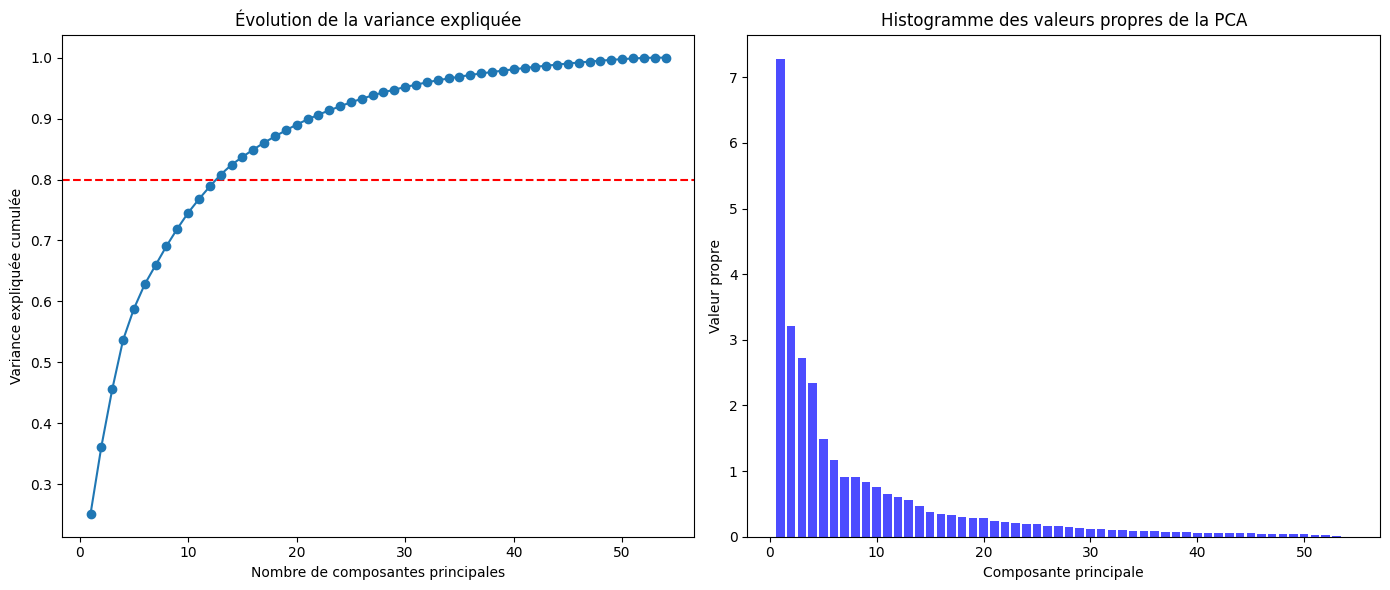

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(np.abs(X))
eigenvalues = pca.explained_variance_
variance_explained = pca.explained_variance_ratio_

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.axhline(y=0.8, color='r', linestyle='--', label='y = 0.9')
plt.plot(np.arange(1, len(variance_explained) + 1), np.cumsum(variance_explained), marker='o', linestyle='-')
plt.title('Évolution de la variance expliquée')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, len(eigenvalues) + 1), eigenvalues, color='blue', alpha=0.7)
plt.title('Histogramme des valeurs propres de la PCA')
plt.xlabel('Composante principale')
plt.ylabel('Valeur propre')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">

Dans le cadre de notre analyse de données, nous menons une Analyse en Composantes Principales (ACP) afin de réduire la dimensionnalité de notre jeu de données tout en préservant un niveau significatif d'information. Notre objectif était de sélectionner un nombre optimal de composantes principales pour expliquer une part importante de la variance totale des données.

Après avoir effectué l'ACP, nous avons identifié que la conservation de 13 composantes principales nous permet de retenir plus de 80% de la variance totale des données. Cette sélection nous a permis de réduire efficacement la dimensionnalité tout en préservant une quantité significative d'information.

De plus, nous avons observé que les 13 premières composantes principales regroupent plus de la moitié des valeurs propres. Cela suggère que ces premières composantes principales capturent les tendances les plus importantes de nos données, ce qui conforte notre choix de conserver 13 composantes principales pour notre analyse.

En conclusion, l'ACP est un outil efficace pour réduire la dimensionnalité de nos données tout en préservant leur structure essentielle.
</div>

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?

In [8]:
#FT parameters
nperseg = 253  # Window size
noverlap = None # Overlap between consecutive windows, None = nperseg//2

# Compute STFT
f, t, X_stft = scipy.signal.stft(X, nperseg=nperseg, noverlap=noverlap)

# Print the dimensions of the STFT matrix
print("Dimensions of STFT matrix (timesteps, frequencies):", X_stft.shape)
print("Time axis shape:", t.shape)
print("Frequency axis shape:", f.shape)

Dimensions of STFT matrix (timesteps, frequencies): (54, 127, 147)
Time axis shape: (147,)
Frequency axis shape: (127,)


<div class="alert alert-block alert-warning">

Après avoir appliqué la Transformée de Fourier à Court Terme (STFT) sur X, la dimension de la matrice STFT_X est de (54, 127, 147).
</div>

4. Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female

(127, 147)


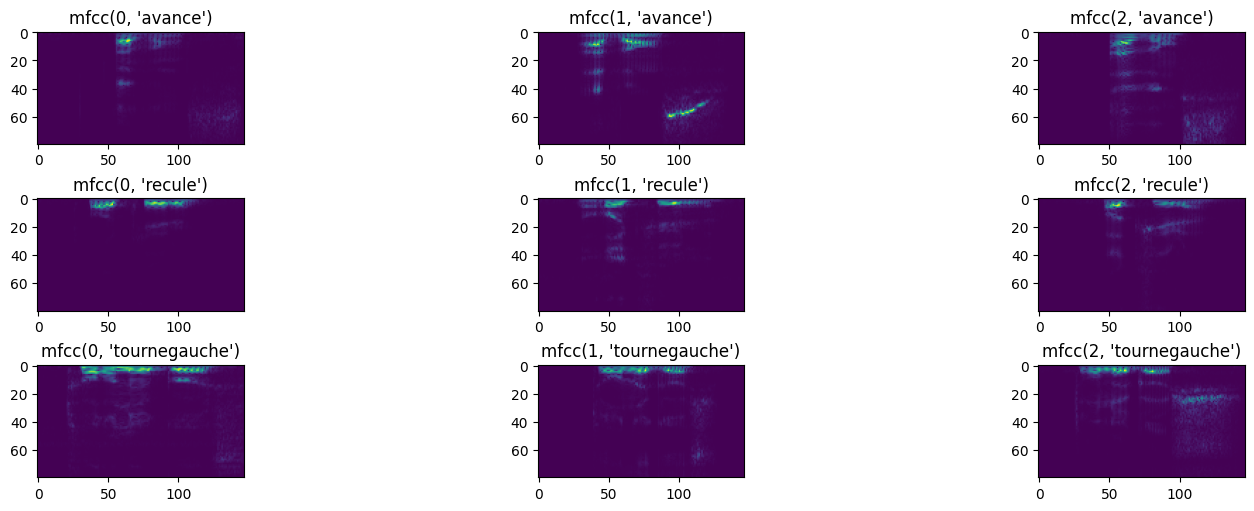

In [9]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance] #for male
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80])) #peu d'infos dans les grandes fréquences
        axs[i,instance].set_title(f'mfcc{instance,word}')


print(Zxx.shape)
plt.show()

(127, 147)


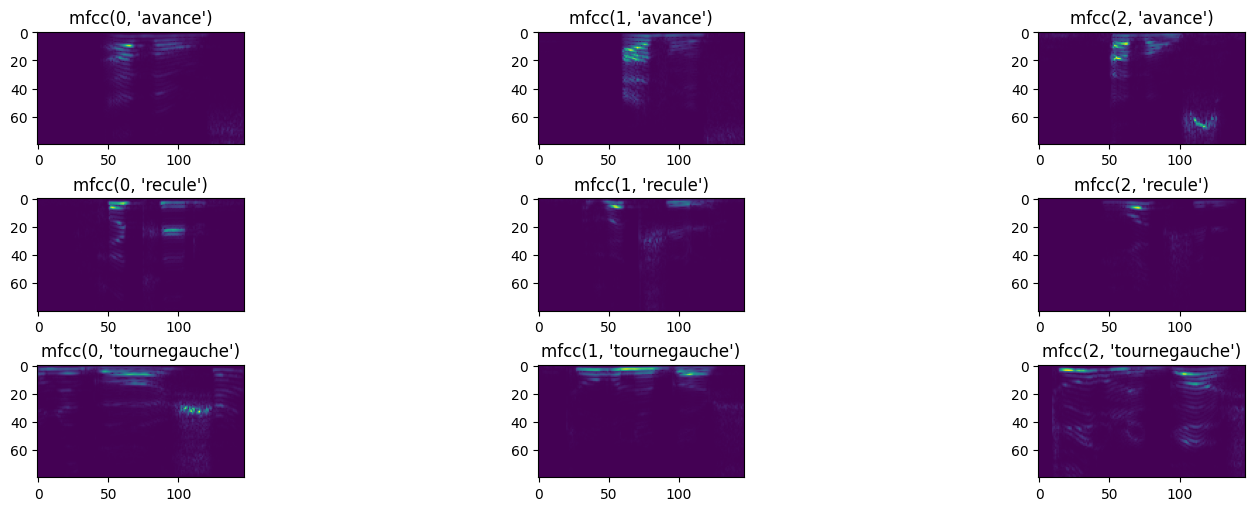

In [10]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance] #for female
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')


print(Zxx.shape)
plt.show()

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT.
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time. Add a second argument that gives the maximum frequency index

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation
        return np.absolute(signal.fft(X)[:self.idx_frequence_max])

In [13]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None, stat=np.mean):
        self.idx_frequence_max = idx_frequence_max
        self.stat = stat

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Calcule la transformée de Fourier à court terme (STFT) de chaque signal dans X
        _, _, Zxx = signal.stft(X, fs=22050, window='hann', nperseg=253, noverlap=None)
        # Si idx_frequence_max est spécifié, ne conserve que les fréquences inférieures à idx_frequence_max
        if self.idx_frequence_max is not None:
            Zxx = Zxx[:, :self.idx_frequence_max]
        # Calcule la statistique souhaitée (moyenne par défaut) pour chaque fréquence et chaque signal
        to_ret = np.apply_along_axis(self.stat, 2, Zxx)

        return to_ret

In [14]:
#Tests
pstft = STFT(stat=np.min, idx_frequence_max=80)
x_chap  = pstft.transform(X)
print(x_chap.shape)
print(x_chap)

(54, 80)
[[-0.00231966+0.00000000e+00j -0.006453  -3.20162522e-04j
  -0.00907636-5.79388304e-03j ... -0.00034591-2.53620911e-04j
  -0.00036464-4.26124935e-05j -0.00043678+6.76912474e-04j]
 [-0.00622838+0.00000000e+00j -0.01262319+4.53072999e-04j
  -0.02051586-3.22592274e-03j ... -0.00140971+2.44545777e-04j
  -0.00158936-8.01599198e-04j -0.00061147-4.81822484e-04j]
 [-0.00497192+0.00000000e+00j -0.01267266-3.09392040e-04j
  -0.02145557-9.55902864e-03j ... -0.00014601+2.76964287e-05j
  -0.00011217+5.60741820e-05j -0.00021857-1.20538143e-04j]
 ...
 [-0.0043414 +0.00000000e+00j -0.01233045+2.49686349e-03j
  -0.0215834 -1.54040606e-03j ... -0.00183009-1.28419485e-03j
  -0.00096156-3.60648430e-04j -0.00125468+1.04970172e-03j]
 [-0.00066311+0.00000000e+00j -0.00187058+1.18335749e-03j
  -0.01307092+6.50965522e-03j ... -0.00023905+1.86704816e-04j
  -0.00058763+7.53871070e-04j -0.00024131-1.13347029e-04j]
 [-0.00408091+0.00000000e+00j -0.01892133-4.35200891e-03j
  -0.02884393+2.18562137e-03j ...

# Partie I : Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }},
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



**Question 0** : (Sans pipeline)
Choisissez un preprocessing. Coder une cross validation pour la regréssion logistique.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#### 0 - Cross validation pour la regréssion logistique sans pipeline

In [16]:
### Cross validation pour la regréssion logistique sans pipeline ###

from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=12)
X_pca = pca.fit_transform(np.abs(X))
pstft = STFT(stat=np.min, idx_frequence_max=80)
X_stft  = pstft.transform(X)

x_prepro= X_pca #à choisir

from sklearn.metrics import accuracy_score

# Génère une permutation aléatoire des indices de x_prepro
index = np.random.permutation(len(x_prepro))

# Mélange les lignes de x_prepro et les éléments de y en utilisant l'index aléatoire
x_prepro = x_prepro[index]
y_shuffled = y[index]

# Divise les données en trois parties égales
un_tier = len(x_prepro) // 3

# Boucle sur les trois parties
for i in range(3):
    # Sélectionne l'index de la partie courante
    if (1+i)*un_tier < len(x_prepro):
        index = range(i * un_tier, (1+i)*un_tier+1)
    else:
        index = range(i * un_tier, len(x_prepro))

    # Crée un tableau booléen pour sélectionner les indices de test
    indices_test = np.zeros(len(x_prepro), dtype=bool)
    indices_test[index] = True

    # Sépare les données en un jeu de test et un jeu d'entraînement
    x_test = x_prepro[indices_test]
    x_train = x_prepro[~indices_test]

    y_test = y_shuffled[indices_test]
    y_train = y_shuffled[~indices_test]

    # Entraîne un modèle de régression logistique sur le jeu d'entraînement
    logistic_model = LogisticRegression(C=1)
    logistic_model.fit(np.real(x_train), y_train)

    # Prédit les étiquettes des données de test
    y_pred = logistic_model.predict(np.real(x_test))

    # Calcule la précision du modèle sur les données de test
    accuracy = accuracy_score(y_test, y_pred)
    print("Score de l'entrainement:", logistic_model.score(x_train,y_train))

    # Affiche la précision du modèle pour la partie courante
    print("Accuracy:", accuracy)

Score de l'entrainement: 0.7714285714285715
Accuracy: 0.47368421052631576
Score de l'entrainement: 0.8
Accuracy: 0.6842105263157895
Score de l'entrainement: 0.8333333333333334
Accuracy: 0.4444444444444444


#### 1 - The first PCA components

In [17]:
from sklearn.model_selection import LeaveOneOut

scaler = StandardScaler()
pca = PCA(n_components=15)
X_pca = pca.fit_transform(np.abs(fft(X)))
X_pca = scaler.fit_transform(X_pca)
logistic_model = LogisticRegression(C = 6)
loo = LeaveOneOut()
accuracy_scores = []

for train_index, test_index in loo.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

print("Accuracy pour la PCA:", np.mean(accuracy_scores))

Accuracy pour la PCA: 0.7777777777777778


In [18]:
# # GridSearch CV (non scale)
# pipeline = Pipeline([
#     ('pca', PCA(n_components=12)),
#     ('logistic', LogisticRegression())
# ])

# param_grid = {'pca__n_components': [10, 20, 30],
#               'logistic__C': [0.1, 1.0, 10.0]}

# loo = LeaveOneOut()

# grid_search = GridSearchCV(pipeline, param_grid, cv=loo, scoring='accuracy', return_train_score=True)

# grid_search.fit(np.abs(fft(X)), y)

# for params, mean_score, std_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
#     print(f"{params} -> Accuracy: {mean_score:.3f} (+/- {std_score:.3f})")

<div class="alert alert-block alert-warning">

Résultats pour la PCA non scale :\
{'logistic__C': 0.1, 'pca__n_components': 10} -> Accuracy: 0.741 (+/- 0.438)\
{'logistic__C': 0.1, 'pca__n_components': 20} -> Accuracy: 0.704 (+/- 0.457)\
{'logistic__C': 0.1, 'pca__n_components': 30} -> Accuracy: 0.722 (+/- 0.448)\
{'logistic__C': 1.0, 'pca__n_components': 10} -> Accuracy: 0.759 (+/- 0.428)\
{'logistic__C': 1.0, 'pca__n_components': 20} -> Accuracy: 0.685 (+/- 0.464)\
{'logistic__C': 1.0, 'pca__n_components': 30} -> Accuracy: 0.722 (+/- 0.448)\
{'logistic__C': 10.0, 'pca__n_components': 10} -> Accuracy: 0.759 (+/- 0.428)\
{'logistic__C': 10.0, 'pca__n_components': 20} -> Accuracy: 0.685 (+/- 0.464)\
{'logistic__C': 10.0, 'pca__n_components': 30} -> Accuracy: 0.704 (+/- 0.457)
</div>

In [19]:
# # GridSearch CV (en scale)
# pipeline = Pipeline([
#     ('pca', PCA(n_components=12)),
#     ('scale', StandardScaler()),
#     ('logistic', LogisticRegression())
# ])

# param_grid = {'pca__n_components': [10, 20, 30],
#               'logistic__C': [0.00001, 0.1, 1.0, 10.0]}

# loo = LeaveOneOut()

# grid_search = GridSearchCV(pipeline, param_grid, cv=loo, scoring='accuracy', return_train_score=True)

# grid_search.fit(np.abs(fft(X)), y)

# for params, mean_score, std_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
#     print(f"{params} -> Accuracy: {mean_score:.3f} (+/- {std_score:.3f})")

<div class="alert alert-block alert-warning">

Résulats pour la PCA scale : \
{'logistic__C': 1e-05, 'pca__n_components': 10} -> Accuracy: 0.000 (+/- 0.000) \
{'logistic__C': 1e-05, 'pca__n_components': 20} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 1e-05, 'pca__n_components': 30} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 0.1, 'pca__n_components': 10} -> Accuracy: 0.685 (+/- 0.464)\
{'logistic__C': 0.1, 'pca__n_components': 20} -> Accuracy: 0.685 (+/- 0.464)\
{'logistic__C': 0.1, 'pca__n_components': 30} -> Accuracy: 0.630 (+/- 0.483)\
{'logistic__C': 1.0, 'pca__n_components': 10} -> Accuracy: 0.741 (+/- 0.438)\
{'logistic__C': 1.0, 'pca__n_components': 20} -> Accuracy: 0.741 (+/- 0.438)\
{'logistic__C': 1.0, 'pca__n_components': 30} -> Accuracy: 0.704 (+/- 0.457)\
{'logistic__C': 10.0, 'pca__n_components': 10} -> Accuracy: 0.759 (+/- 0.428)\
{'logistic__C': 10.0, 'pca__n_components': 20} -> Accuracy: 0.759 (+/- 0.428)\
{'logistic__C': 10.0, 'pca__n_components': 30} -> Accuracy: 0.759 (+/- 0.428)
</div>

<div class="alert alert-block alert-warning">

ANALYSE GLOBALE

Pour les données non scalées :

1. Lorsque 'logistic__C' est fixé à 0.1, l'exactitude atteint 0.741 avec 10 composantes PCA. Ensuite, elle diminue légèrement à 0.704 avec 20 composantes PCA et remonte à 0.722 avec 30 composantes.
2. Lorsque 'logistic__C' est fixé à 1.0, l'exactitude est maximale (0.759) avec 10 composantes PCA, puis diminue à 0.685 avec 20 composantes PCA avant d'augmenter à nouveau à 0.722 avec 30 composantes.
3. Lorsque 'logistic__C' est fixé à 10.0, l'exactitude est également maximale (0.759) avec 10 composantes PCA. Pour 20 composantes PCA, l'exactitude diminue à 0.685, puis remonte légèrement à 0.704 avec 30 composantes PCA.

Pour les données scalées :

1. Lorsque 'logistic__C' est fixé à 1e-05, l'exactitude est nulle pour toutes les valeurs de composantes PCA testées (10, 20, et 30).
2. Lorsque 'logistic__C' est fixé à 0.1, l'exactitude est maximale (0.685) avec 10 et 20 composantes PCA, puis diminue légèrement à 0.630 avec 30 composantes PCA.
3. Lorsque 'logistic__C' est fixé à 1.0, l'exactitude est maximale (0.741) avec 10 composantes PCA, puis reste stable à 0.741 avec 20 composantes PCA, et diminue légèrement à 0.704 avec 30 composantes PCA.
4. Lorsque 'logistic__C' est fixé à 10.0, l'exactitude est maximale (0.759) avec toutes les valeurs de composantes PCA (10, 20, et 30).

En conclusion, il semble que pour les deux ensembles de données, un 'logistic__C' de 10.0 et 10 composantes PCA donnent les meilleurs résultats en termes d'exactitude. Cependant, l'écart-type élevé suggère une grande variabilité dans les résultats, ce qui pourrait être dû à une petite taille d'échantillon ou à une grande variabilité dans les données elles-mêmes.
</div>

#### 2 - Different statistics and maximum frequency of the STFT

In [20]:
pstft = STFT(stat=np.max, idx_frequence_max=80)
X_stft  = pstft.transform(X)
logistic_model = LogisticRegression(C=100)

loo = LeaveOneOut()
accuracy_scores = []

for train_index, test_index in loo.split(X_stft):
    X_train, X_test = X_stft[train_index], X_stft[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logistic_model.fit(np.real(X_train), y_train)
    y_pred = logistic_model.predict(np.real(X_test))

    accuracy = logistic_model.score(np.real(X_test), y_test)
    accuracy_scores.append(accuracy)

print("Accuracy:", np.mean(accuracy_scores))

Accuracy: 0.7037037037037037


In [21]:
# # GridSearch CV (non scale)
# from sklearn.preprocessing import FunctionTransformer
# pipeline = Pipeline([
#     ('stft', STFT(stat=np.min, idx_frequence_max=80)),
#     ('real', FunctionTransformer(np.real)),
#     ('logistic', LogisticRegression())
# ])

# param_grid = {'stft__stat': [np.min, np.max],
#               'logistic__C': [0.00001, 0.1, 1.0, 10.0]}

# loo = LeaveOneOut()

# grid_search = GridSearchCV(pipeline, param_grid, cv=loo, scoring='accuracy', return_train_score=True)

# grid_search.fit(X, y)

# for params, mean_score, std_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
#     print(f"{params} -> Accuracy: {mean_score:.3f} (+/- {std_score:.3f})")

<div class="alert alert-block alert-warning">
    
Résultats SFTF non scale :\
{'logistic__C': 1e-05, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 1e-05, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 0.1, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 0.1, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 1.0, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.037 (+/- 0.189)\
{'logistic__C': 1.0, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.074 (+/- 0.262)\
{'logistic__C': 10.0, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.500 (+/- 0.500)\
{'logistic__C': 10.0, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.426 (+/- 0.494)
</div>

In [22]:
# # Recherche du meilleur C à un nb_compo fixé
# from sklearn.preprocessing import FunctionTransformer
# pipeline = Pipeline([
#     ('stft', STFT(stat=np.min, idx_frequence_max=80)),
#     ('real', FunctionTransformer(np.real)),
#     ('scale', StandardScaler()),
#     ('logistic', LogisticRegression())
# ])

# param_grid = {'stft__stat': [np.min, np.max],
#               'logistic__C': [0.00001, 0.1, 1.0, 10.0]}

# loo = LeaveOneOut()

# grid_search = GridSearchCV(pipeline, param_grid, cv=loo, scoring='accuracy', return_train_score=True)

# grid_search.fit(X, y)

# for params, mean_score, std_score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
#     print(f"{params} -> Accuracy: {mean_score:.3f} (+/- {std_score:.3f})")

<div class="alert alert-block alert-warning">

Résultats STFT scale :\
{'logistic__C': 1e-05, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 1e-05, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.000 (+/- 0.000)\
{'logistic__C': 0.1, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.778 (+/- 0.416)\
{'logistic__C': 0.1, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.778 (+/- 0.416)\
{'logistic__C': 1.0, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.759 (+/- 0.428)\
{'logistic__C': 1.0, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.796 (+/- 0.403)\
{'logistic__C': 10.0, 'stft__stat': <function amin at 0x7fce1c0f3e20>} -> Accuracy: 0.704 (+/- 0.457)\
{'logistic__C': 10.0, 'stft__stat': <function amax at 0x7fce1c0f3c70>} -> Accuracy: 0.852 (+/- 0.355)

</div>

<div class="alert alert-block alert-warning">
    
ANALYSE GLOBALE \
Pour les données SFTF non mises à l'échelle :

1. Lorsque 'logistic__C' est fixé à 1e-05 et 'stft__stat' à 'amin' ou 'amax', l'exactitude est nulle pour toutes les combinaisons de paramètres testées.
2. Lorsque 'logistic__C' est fixé à 0.1 et 'stft__stat' à 'amin' ou 'amax', l'exactitude est toujours nulle.
3. Lorsque 'logistic__C' est fixé à 1.0 et 'stft__stat' à 'amin', l'exactitude est de 0.037 (+/- 0.189), ce qui est très faible. Pour 'amax', l'exactitude est de 0.074 (+/- 0.262).
4. Lorsque 'logistic__C' est fixé à 10.0 et 'stft__stat' à 'amin', l'exactitude est de 0.500 (+/- 0.500), ce qui est relativement élevé mais associé à un écart-type important. Pour 'amax', l'exactitude est de 0.426 (+/- 0.494), également avec un écart-type élevé.

Pour les données SFTF mises à l'échelle :

1. Lorsque 'logistic__C' est fixé à 1e-05 et 'stft__stat' à 'amin' ou 'amax', l'exactitude est nulle pour toutes les combinaisons de paramètres testées.
2. Lorsque 'logistic__C' est fixé à 0.1 et 'stft__stat' à 'amin' ou 'amax', l'exactitude est de 0.778 (+/- 0.416) dans les deux cas, ce qui est relativement élevé.
3. Lorsque 'logistic__C' est fixé à 1.0 et 'stft__stat' à 'amin', l'exactitude est de 0.759 (+/- 0.428), avec un écart-type assez élevé. Pour 'amax', l'exactitude est légèrement plus élevée à 0.796 (+/- 0.403).
4. Lorsque 'logistic__C' est fixé à 10.0 et 'stft__stat' à 'amin', l'exactitude est de 0.704 (+/- 0.457). Pour 'amax', l'exactitude est de 0.852 (+/- 0.355), avec une exactitude moyenne relativement élevée et un écart-type plus faible que les autres cas.

En conclusion, pour les données SFTF mises à l'échelle, les performances de la régression logistique semblent être meilleures, avec des exactitudes plus élevées et des écarts-types plus faibles par rapport aux données non mises à l'échelle. En particulier, pour 'logistic__C' fixé à 10.0 et 'stft__stat' à 'amax', l'exactitude moyenne est la plus élevée (0.852) avec un écart-type relativement faible (0.355), ce qui suggère une certaine stabilité dans les performances du modèle.
</div>

#### 3 - Evaluation of results

Evaluate the result by confusion matrix and percentage of correct classification.

*Tip:* Remember to put a function to display the confusion matrix

Pourcentage de classification correcte: 0.8333333333333334


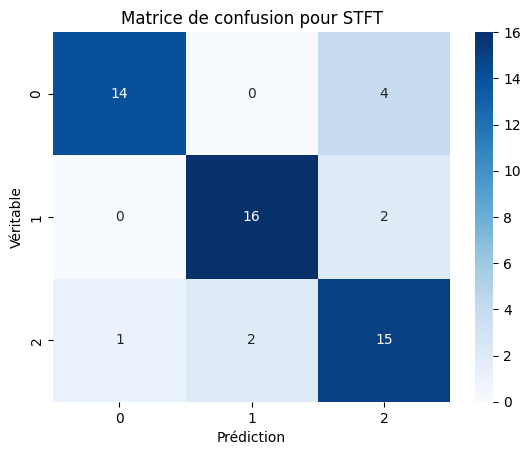

In [23]:
# Evaluation des résultats par matrices de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#Best_model STFT : {'logistic__C': 10.0, 'stft__stat': <function amax at 0x7f11b97c0310>} -> Accuracy: 0.852 (+/- 0.355)

pstft = STFT(stat=np.max, idx_frequence_max=80)
X_stft  = pstft.transform(X)

scaler = StandardScaler()
X_stft_scaled = scaler.fit_transform(np.real(X_stft))

logistic_model = LogisticRegression(C=10)

loo = LeaveOneOut()
accuracy_scores = []
y_pred_all = []
y_test_all=[]

for train_index, test_index in loo.split(X_stft_scaled):
    X_train, X_test = X_stft_scaled[train_index], X_stft_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    accuracy = logistic_model.score(X_test, y_test)
    accuracy_scores.append(accuracy)

    y_test_all.append(y_test)
    y_pred_all.append(y_pred)

print("Pourcentage de classification correcte:", np.mean(accuracy_scores))

# Convertir la liste de prédictions en tableau 1D
y_pred_all = np.concatenate(y_pred_all)
y_test_all = np.concatenate(y_test_all)

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test_all, y_pred_all)

# Créer un heatmap à partir de la matrice de confusion
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')

# Ajouter les labels des axes
plt.xlabel('Prédiction')
plt.ylabel('Véritable')

# Ajouter un titre
plt.title('Matrice de confusion pour STFT')

# Afficher la légende
plt.show()

<div class="alert alert-block alert-warning">

Après avoir appliqué une Transformée de Fourier à Court Terme (STFT) sur nos données, nous avons évalué les performances de notre modèle de classification en analysant la matrice de confusion.

Cette matrice de confusion nous fournit un aperçu détaillé des prédictions de notre modèle par rapport aux vraies étiquettes des données. Voici une analyse des résultats :

- **Classe 0** : 14 observations ont été correctement classées, tandis que 4 ont été prédites comme appartenant à la classe 0.
- **Classe 1** : Toutes les 16 observations appartenant à cette classe ont été correctement classées.
- **Classe 2** : 15 observations ont été correctement classées, avec 1 observation prédite à tort comme appartenant à la classe 0 et 2 autres prédites à tort comme appartenant à la classe 1.

Globalement, notre modèle a montré de bonnes performances, avec une majorité d'observations correctement classées dans chaque classe. Cependant, des erreurs ont été observées, principalement dans la classification des observations de la classe 2.
</div>

Pourcentage de classification correcte: 0.8148148148148148


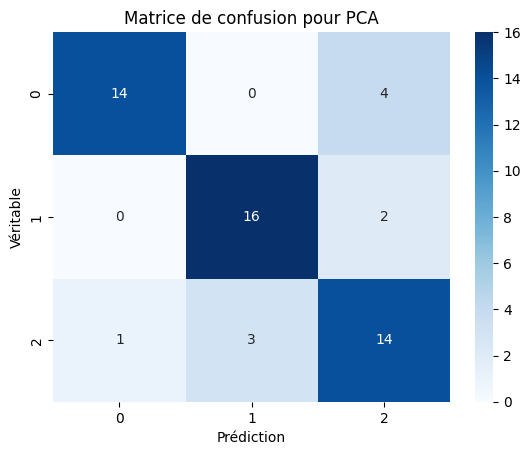

In [24]:
scaler = StandardScaler()
pca = PCA(n_components=10)
X_pca = pca.fit_transform(np.abs(fft(X)))
X_pca = scaler.fit_transform(X_pca)


logistic_model = LogisticRegression(C = 6)
loo = LeaveOneOut()
accuracy_scores = []
y_pred_all = []
y_test_all=[]

for train_index, test_index in loo.split(X_stft_scaled):
    X_train, X_test = X_stft_scaled[train_index], X_stft_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    logistic_model.fit(X_train, y_train)
    y_pred = logistic_model.predict(X_test)

    accuracy = logistic_model.score(X_test, y_test)
    accuracy_scores.append(accuracy)

    y_test_all.append(y_test)
    y_pred_all.append(y_pred)

print("Pourcentage de classification correcte:", np.mean(accuracy_scores))

# Convertir la liste de prédictions en tableau 1D
y_pred_all = np.concatenate(y_pred_all)
y_test_all = np.concatenate(y_test_all)

# Matrice de confusion
cnf_matrix = confusion_matrix(y_test_all, y_pred_all)

# Créer un heatmap à partir de la matrice de confusion
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues')

# Ajouter les labels des axes
plt.xlabel('Prédiction')
plt.ylabel('Véritable')

# Ajouter un titre
plt.title('Matrice de confusion pour PCA')

# Afficher la légende
plt.show()


<div class="alert alert-block alert-warning">

Cette matrice de confusion fournit une vue détaillée des prédictions de notre modèle par rapport aux vraies étiquettes des données. Voici une analyse des résultats :

- **Classe 0** : 14 observations ont été correctement classées, tandis que 4 ont été prédites à tort comme appartenant à la classe 2.
- **Classe 1** : Toutes les 16 observations appartenant à cette classe ont été correctement classées.
- **Classe 2** : 14 observations ont été correctement classées, mais 1 observation a été prédite à tort comme appartenant à la classe 0, et 3 autres ont été prédites à tort comme appartenant à la classe 2.

Globalement, notre modèle a montré de bonnes performances, avec une majorité d'observations correctement classées dans chaque classe. Cependant, des erreurs ont été observées, principalement dans la classification des observations de la classe 2.
</div>

# Part II: Classification by kernel methods

**Reminder** Kernel methods consist of plunging the data into a space of Hilbert dimension $\mathcal{H}$ where the data can be separated linearly.

**Representation Theorem:** The solution of the infinite dimensional separation problem is contained in a finite dimensional vector subspace of $\mathcal{H}$

### 1. Perform a core SVM classification

    1) Vary the core
    2) Vary the regularization parameter.

In [25]:
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.svm import SVC, LinearSVC

# stft = STFT(idx_frequence_max=80, stat=np.mean)
# scaler = StandardScaler()
# svm = SVC(kernel='linear', C=1.0)

# pipeline2 = Pipeline([
# ('stft', stft),
# ('real', FunctionTransformer(np.real)),
# ('scaler', scaler),
# ('svm', svm)
# ])


# param_grid2 = {
# 'stft__stat': [np.mean, np.max],
# 'svm__C': [0.1, 1.0, 10.0,100.0],
# 'svm__kernel': ['linear', 'rbf', 'poly'],
# 'svm__gamma' : [0.1, 1.0, 10.0,100.0],
# }

# loo = LeaveOneOut()

# grid_search2 = GridSearchCV(pipeline2, param_grid2, cv=loo)
# grid_search2.fit(np.real(X), y)

# print("Résultats du deuxième pipeline :")
# best_score = grid_search2.best_score_
# print(f"Meilleur score : {best_score:.4f}")

# best_params = grid_search2.best_params_
# print(f"Meilleurs paramètres : {best_params}")

# mean_scores = grid_search2.cv_results_['mean_test_score']
# std_scores = grid_search2.cv_results_['std_test_score']
# param_combinations = [param for param in grid_search2.cv_results_['params']]

# print("\nScores pour chaque combinaison de paramètres :")
# for i, param in enumerate(param_combinations):
#     print(f"{param} : {mean_scores[i]:.4f} ± {std_scores[i]:.4f}")

<div class="alert alert-block alert-warning">
Résultats de la meilleure combinaison pour chaque noyau :

Pour le noyau linéaire :
- {'stft__stat': <function amax at 0x7fce1c0f3c70>, 'svm__C': 10.0, 'svm__gamma': 0.1, 'svm__kernel': 'linear'} : 0.7593 ± 0.4275

Pour le noyau RBF :
- {'stft__stat': <function amax at 0x7fce1c0f3c70>, 'svm__C': 10.0, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'} : 0.5556 ± 0.4969

Pour le noyau polynomial :
- {'stft__stat': <function amax at 0x7fce1c0f3c70>, 'svm__C': 1.0, 'svm__gamma': 0.1, 'svm__kernel': 'poly'} : 0.6852 ± 0.4644
</div>

### 2. Visualisation de la SVM dans le plan des deux premières composantes de la PCA

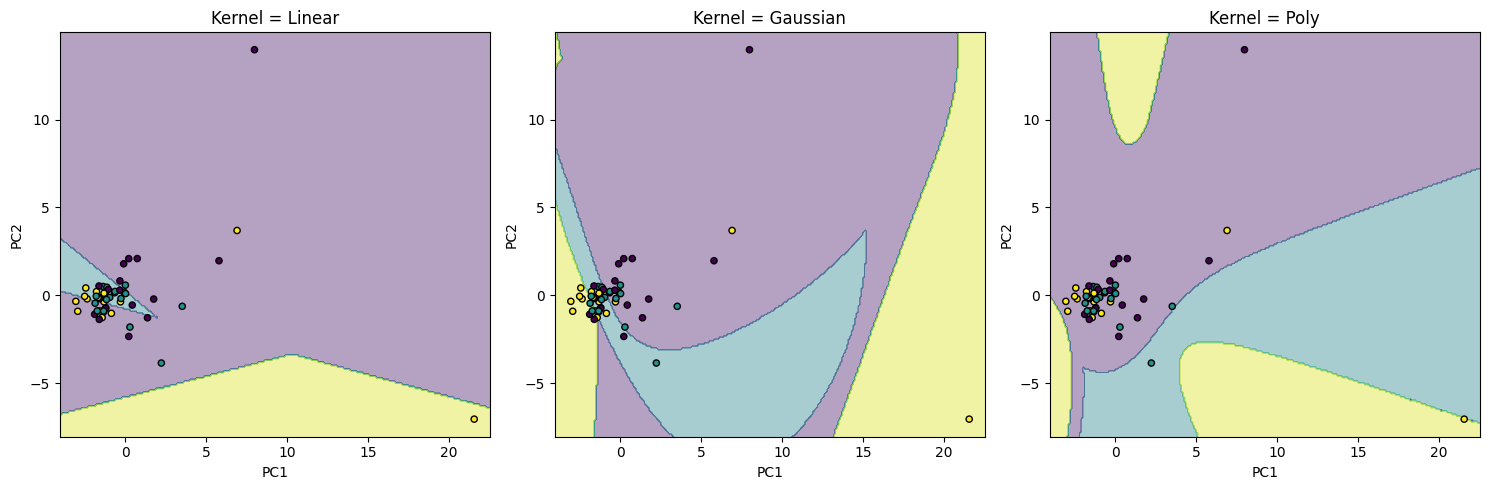

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
pca = PCA(n_components=2)

# Kernel = linear
stft = STFT(stat=np.max, idx_frequence_max=80)
X_stft  = stft.fit_transform(X)
scaler = StandardScaler()
X_stft_scaled = scaler.fit_transform(np.real(X_stft))
X_pca = pca.fit_transform(np.abs(X_stft_scaled))

clf_linear = SVC(kernel='linear', C=10.0, gamma=0.1)
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf_linear.fit(X_trainl, y_trainl)
y_predl = clf_linear.predict(X_testl)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx_linear, yy_linear = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z_linear = clf_linear.predict(np.c_[xx_linear.ravel(), yy_linear.ravel()])
Z_linear = Z_linear.reshape(xx_linear.shape)

# Kernel = Gaussian
clf_gaussian = SVC(kernel='rbf', C=10, gamma=0.01)
X_traing, X_testg, y_traing, y_testg = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf_gaussian.fit(X_traing, y_traing)
y_predg = clf_gaussian.predict(X_testg)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx_gaussian, yy_gaussian = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z_gaussian = clf_gaussian.predict(np.c_[xx_gaussian.ravel(), yy_gaussian.ravel()])
Z_gaussian = Z_gaussian.reshape(xx_gaussian.shape)

# Kernel = Poly
clf_poly = SVC(kernel='poly', C=1, gamma=0.1)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf_poly.fit(X_trainp, y_trainp)
y_predp = clf_poly.predict(X_testp)

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx_poly, yy_poly = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z_poly = clf_poly.predict(np.c_[xx_poly.ravel(), yy_poly.ravel()])
Z_poly = Z_poly.reshape(xx_poly.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Une ligne, trois sous-graphiques

# Affichage du graphique Kernel = Linear
axes[0].contourf(xx_linear, yy_linear, Z_linear, alpha=0.4)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Kernel = Linear')

# Affichage du graphique Kernel = Gaussian
axes[1].contourf(xx_gaussian, yy_gaussian, Z_gaussian, alpha=0.4)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Kernel = Gaussian')

# Affichage du graphique Kernel = Poly
axes[2].contourf(xx_poly, yy_poly, Z_poly, alpha=0.4)
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].set_title('Kernel = Poly')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
Lors de la visualisation de la Support Vector Machine (SVM) dans le plan des deux premières composantes de l'Analyse en Composantes Principales (PCA), selon trois noyaux différents (linéaire, gaussien et polynômial), plusieurs observations peuvent être faites pour évaluer la séparation des classes dans l'espace transformé :

1. **Noyau Linéaire** :
   - Avec le noyau linéaire, nous observons des droites dans le plan, ce qui indique que la SVM cherche à séparer linéairement les classes dans l'espace des deux premières composantes principales de la PCA.
   - Si les classes sont linéairement séparables, cette approche peut être efficace et la visualisation montre une séparation nette entre les classes.


2. **Noyau Gaussien** :
   - Avec le noyau gaussien, nous observons des formes de gaussiennes dans le plan, ce qui suggère une séparation non linéaire des classes dans l'espace transformé.
   - Ce noyau est utile lorsque les classes ne sont pas linéairement séparables et permet de capturer des relations plus complexes entre les données.


3. **Noyau Polynômial** :
   - Avec le noyau polynômial, nous observons des formes de polynômes dans le plan, indiquant une tentative de séparation des classes par des surfaces polynomiales.
   - Comme le noyau gaussien, le noyau polynômial peut être efficace pour capturer des relations non linéaires entre les données.

En analysant ces visualisations, nous pouvons évaluer la performance et la pertinence des différents noyaux de la SVM pour notre tâche de classification. Si les classes sont linéairement séparables, le noyau linéaire peut être préférable pour sa simplicité et son interprétabilité. Cependant, si les classes sont non linéairement séparables, les noyaux gaussien ou polynômial peuvent être plus appropriés pour capturer des structures complexes dans les données.

En conclusion, la visualisation de la SVM dans le plan des deux premières composantes de la PCA selon différents noyaux permet d'évaluer visuellement la séparation des classes et de choisir le noyau le plus adapté à notre problème de classification, en fonction de la complexité des données et de la nature des relations entre les variables.

NB : Dans notre cas, notre visualisation en deux dimensions ne nous permet pas de conclusion particulière.
</div>

# Part III: Ensemble Method

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [28]:
### 1. create y1
y1= np.where(y == 1, 1, 0)
scale = StandardScaler()
x_scaled = scale.fit_transform(X)
pstft = STFT(stat=np.max, idx_frequence_max=80)
x_chap  = np.abs(pstft.transform(x_scaled))

In [29]:
### 2. Bagging
M=100
max_depth=2
X_train, X_test, y_train, y_test = train_test_split(x_chap,y1,test_size=0.4, random_state=42)
accuracies = []
list_model=[]
liste_pred=[]
for m in range(M):


    idx = np.random.randint(0,len(X_train),len(X_train))
    X_train_bootstrap = X_train[idx]
    y_train_bootstrap = y_train[idx]

    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train_bootstrap, y_train_bootstrap)
    list_model.append(tree)

    y_pred = tree.predict(X_test)
    liste_pred.append(y_pred)

    # Calcul de l'exactitude
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

mean_accuracy_models = np.mean(accuracies)

# Entraînement du modèle Bagging
liste_pred=np.array(liste_pred)
y_pred_bagging = np.round(np.mean(liste_pred,axis=0))
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)

# mean_models = np.mean(liste_pred,axis=0)
# mean_models = [0 if elem > 0.5 else 1 for elem in mean_models]
# mean_accuracy_models=accuracy_score(y_test, mean_models)

print("Mean accuracy of individual models:", mean_accuracy_models)
print("Accuracy of bagging model:", accuracy_bagging)

Mean accuracy of individual models: 0.7468181818181818
Accuracy of bagging model: 0.9090909090909091


<div class="alert alert-block alert-warning">
L'analyse des performances du modèle montre que l'accuracy obtenue grâce à la méthode de bagging est supérieure à la simple moyenne des accuracies des modèles individuels. 

Le bagging, ou bootstrap aggregating, consiste à construire plusieurs modèles en utilisant des sous-ensembles aléatoires de données d'entraînement, puis à combiner leurs prédictions. Cette combinaison se fait généralement par une moyenne ou un vote majoritaire (ce qui est le cas ici car nous faisons de la classification), produisant un modèle final plus performant et stable. 

Un arbre de décision seul peut avoir des résultats variables en raison de sa sensibilité aux fluctuations des données d'entraînement. Cette instabilité se traduit par des accuracies qui peuvent fluctuer d'une instance à l'autre. En revanche, le modèle obtenu par bagging atténue cette variabilité. En agrégeant les résultats de plusieurs arbres de décision, le bagging produit un modèle avec une performance plus stable, ce qui explique pourquoi son accuracy globale est souvent supérieure à la moyenne des accuracies des arbres individuels.

En résumé, bien qu'il puisse exister des arbres de décision individuels avec une accuracy supérieure à celle du modèle de bagging, la stabilité accrue apportée par le bagging permet d'obtenir une meilleure performance moyenne, et donc une accuracy généralement plus élevée.
</div>

In [30]:
# from sklearn.ensemble import RandomForestClassifier

# pipeline_rf = Pipeline([
# ('random_forest', RandomForestClassifier(random_state=42))
# ])


# param_grid_rf = {
# 'random_forest__n_estimators': [100,200,500],
# 'random_forest__max_depth': [2,3,5],
# 'random_forest__max_features': ['sqrt', 'log2'],
# }

# loo=LeaveOneOut()
# grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf,cv=loo)
# grid_search_rf.fit(np.real(x_chap), y)

# print("Résultats du deuxième pipeline :")
# best_score = grid_search_rf.best_score_
# print(f"Meilleur score : {best_score:.4f}")

# best_params = grid_search_rf.best_params_
# print(f"Meilleurs paramètres : {best_params}")

# mean_scores = grid_search_rf.cv_results_['mean_test_score']
# std_scores = grid_search_rf.cv_results_['std_test_score']
# param_combinations = [param for param in grid_search_rf.cv_results_['params']]

# print("\nScores pour chaque combinaison de paramètres :")
# for i, param in enumerate(param_combinations):
#     print(f"{param} : {mean_scores[i]:.4f} ± {std_scores[i]:.4f}")

<div class="alert alert-block alert-warning">

Résultats du deuxième pipeline :

Meilleur score : 0.6667\
Meilleurs paramètres : {'random_forest__max_depth': 3, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200}

Scores pour chaque combinaison de paramètres :\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 100} : 0.5741 ± 0.4945\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200} : 0.6296 ± 0.4829\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 500} : 0.5926 ± 0.4914\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 100} : 0.5741 ± 0.4945\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 200} : 0.5926 ± 0.4914\
{'random_forest__max_depth': 2, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 500} : 0.5926 ± 0.4914\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 100} : 0.6481 ± 0.4775\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200} : 0.6667 ± 0.4714\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 500} : 0.6667 ± 0.4714\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 100} : 0.5741 ± 0.4945\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 200} : 0.5926 ± 0.4914\
{'random_forest__max_depth': 3, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 500} : 0.6111 ± 0.4875\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 100} : 0.6111 ± 0.4875\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 200} : 0.6481 ± 0.4775\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 500} : 0.6296 ± 0.4829\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 100} : 0.6111 ± 0.4875\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 200} : 0.5741 ± 0.4945\
{'random_forest__max_depth': 5, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 500} : 0.5926 ± 0.4914

Analyse : 
Pour la classification avec Random Forest, le nombre de variables sélectionnées est souvent égal à la racine carrée du nombre total de variables disponibles. Cette méthode de sélection (max_features='sqrt') est une pratique courante qui aide à réduire la variance tout en maintenant une bonne performance du modèle.

Lors de notre étude, nous avons effectué une cross-validation pour déterminer les meilleurs paramètres pour notre modèle de Random Forest. Cependant, il est apparu que les paramètres obtenus à partir de cette cross-validation n'ont pas toujours donné les meilleurs résultats lorsque nous les avons appliqués à notre ensemble de données. Cela est normal, vu que la variance est proche de 0.5 pour tous les tests de paramètres.

</div>

In [31]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_chap,y,test_size=0.4, random_state=40)
# Initialize and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42,max_features="sqrt")
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Random Forest classifier:", accuracy)

Accuracy of Random Forest classifier: 0.7272727272727273


<div class="alert alert-block alert-warning">
Random Forest est en effet un type de modèle de type bagging. Il construit plusieurs arbres de décision lors de l'entraînement et fusionne leurs prédictions en moyennant (pour la régression) ou en votant (pour la classification). Chaque arbre dans le Random Forest est entraîné sur un sous-ensemble différent des données d'entraînement, échantillonné de manière aléatoire avec remplacement. De plus, Random Forest introduit de l'aléatoire lors de la construction des arbres en ne considérant qu'un sous-ensemble aléatoire des caractéristiques à chaque division.

</div>

In [32]:
# #Bagging à 3 classes
# from sklearn.ensemble import BaggingClassifier

# pipeline_b = Pipeline([
# ('bagging', BaggingClassifier(random_state=42))
# ])


# param_grid_b = {
# 'bagging__n_estimators': [100,200,500],
# }

# loo=LeaveOneOut()
# grid_search_b = GridSearchCV(pipeline_b, param_grid_b,cv=loo)
# grid_search_b.fit(np.real(x_chap), y)

# print("Résultats du deuxième pipeline :")
# best_score = grid_search_b.best_score_
# print(f"Meilleur score : {best_score:.4f}")

# best_params = grid_search_b.best_params_
# print(f"Meilleurs paramètres : {best_params}")

# mean_scores = grid_search_b.cv_results_['mean_test_score']
# std_scores = grid_search_b.cv_results_['std_test_score']
# param_combinations = [param for param in grid_search_b.cv_results_['params']]

# print("\nScores pour chaque combinaison de paramètres :")
# for i, param in enumerate(param_combinations):
#     print(f"{param} : {mean_scores[i]:.4f} ± {std_scores[i]:.4f}")


<div class="alert alert-block alert-warning">

Résultats du deuxième pipeline :
Meilleur score : 0.7963
Meilleurs paramètres : {'bagging__n_estimators': 100}

Scores pour chaque combinaison de paramètres :\
{'bagging__n_estimators': 100} : 0.7963 ± 0.4028\
{'bagging__n_estimators': 200} : 0.7778 ± 0.4157\
{'bagging__n_estimators': 500} : 0.7963 ± 0.4028

Les résultats révèlent que le meilleur score, atteignant 0.7963, a été obtenu lorsque le nombre d'estimateurs était fixé à 100. Cependant, les scores pour les configurations avec 200 et 500 estimateurs sont très proches (0.7778 et 0.7963, respectivement), et les variances associées sont importantes. Ces observations rendent difficile toute conclusion définitive sur l'impact du nombre d'estimateurs sur les performances du modèle. Les performances similaires et les grandes variances indiquent que l'ajout d'estimateurs supplémentaires n'apporte pas de bénéfice notable en termes de précision, et que le modèle atteint son niveau optimal de généralisation avec un nombre modéré d'estimateurs.
</div>

In [33]:
from sklearn.ensemble import BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(x_chap,y,test_size=0.4, random_state=40)
# Initialize and train Random Forest classifier
rf_classifier = BaggingClassifier(n_estimators=100,random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Bagging classifier:", accuracy)

Accuracy of Bagging classifier: 0.7727272727272727


<div class="alert alert-block alert-warning">
Dans cette analyse, nous avons comparé les performances du Bagging et du Random Forest sur un problème de classification impliquant trois classes. Nos résultats montrent que le Bagging a des performances inférieures par rapport au Random Forest. Ce constat est cohérent avec les caractéristiques théoriques de ces deux méthodes. Le Random Forest est une version améliorée du Bagging, où une sélection aléatoire de variables est effectuée à chaque décision de chaque arbre. Cette sélection aléatoire permet de rendre les arbres plus indépendants les uns des autres, ce qui réduit le risque de surapprentissage (overfitting). Cette indépendance accrue entre les arbres contribue à de meilleures performances globales. Les résultats de nos GridSearch confirment cette supériorité, le modèle Random Forest ayant obtenu une meilleure accuracy par rapport au Bagging.
</div>

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	= t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [34]:
class AdaBoost:
    def __init__(self, BaseClassifierClass, num_clfs):
        self.BaseClassifierClass = BaseClassifierClass
        self.num_clfs = num_clfs
        self.alpha = np.zeros(self.num_clfs)
        self.clfs = [self.BaseClassifierClass(max_depth=3,min_samples_split=5,random_state=42) for _ in range(self.num_clfs)]

    def fit(self, X, y):
        N = len(y)
        w = np.ones(N) / N
        for m in range(self.num_clfs):
            self.clfs[m].fit(X, y, sample_weight=w)
            mistakes = (self.clfs[m].predict(X) != y) 
            ep = max(1e-8,np.sum(w * mistakes)/np.sum(w))
            self.alpha[m] = np.log((1.0 -ep)/ ep)
            w = w * np.exp(self.alpha[m] * mistakes)
            w = w / np.sum(w)

    def predict(self, X):
        base_pred = np.zeros((self.num_clfs, len(X)))
        for m in range(self.num_clfs):
            base_pred[m] = self.clfs[m].predict(X)
        return np.sign(base_pred.T @ self.alpha)

In [35]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = train_test_split(x_chap, y1, test_size=0.3, random_state=42)

ada_classifier = AdaBoost(DecisionTreeClassifier, num_clfs=100)
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy of AdaBoost classifier:", accuracy_ada)

bagging_classifier = BaggingClassifier(n_estimators=100,random_state=42)
bagging_classifier.fit(X_train, y_train)
y_pred_bagging = bagging_classifier.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy of Bagging classifier:", accuracy_bagging)


ada_sk = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,min_samples_split=5,random_state=42),n_estimators=100,algorithm="SAMME", random_state=42)
ada_sk.fit(X_train, y_train)
y_pred_adask = ada_sk.predict(X_test)

accuracy_adask = accuracy_score(y_test, y_pred_adask)
print("Accuracy of AdaBoost de sklearn:", accuracy_adask)

Accuracy of AdaBoost classifier: 0.9411764705882353
Accuracy of Bagging classifier: 0.8823529411764706
Accuracy of AdaBoost de sklearn: 0.8823529411764706


<div class="alert alert-block alert-warning">
AdaBoost et Bagging produisent des résultats comparables, cependant, cela dépend fortement de la manière dont les données sont séparées. Les évaluations actuelles montrent que l'Accuracy du classifieur AdaBoost atteint 0.941 et celle du classifieur Bagging atteint 0.882. Il est intéressant de noter que l'accuracy d'AdaBoost, implémenté via la bibliothèque sklearn, est également de 0.882, ce qui reflète la sensibilité de ces techniques aux variations dans la répartition des données.
</div>

**Question 2 :**
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [36]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# np.random.seed(42)
# # Adaboost with Decision Tree
# adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))

# # Define parameter grid for Adaboost
# param_grid_adaboost = {
#     'n_estimators': [25,50,100,150],
#     'learning_rate': [1.0,1.5,2.0]
# }

# # Perform GridSearchCV with Leave One Out Cross Validation
# loo = LeaveOneOut()
# grid_search_adaboost = GridSearchCV(adaboost, param_grid_adaboost, cv=loo)
# grid_search_adaboost.fit(x_chap, y)

# print("Best parameters for Adaboost with Decision Tree:", grid_search_adaboost.best_params_)

<div class="alert alert-block alert-warning">
Best parameters for Adaboost with Decision Tree: {'learning_rate': 2.0, 'n_estimators': 100}
</div>

In [37]:
# # Gradient Boosting
# gradient_boosting = GradientBoostingClassifier(max_depth=2)
# np.random.seed(42)

# # Define parameter grid for Gradient Boosting
# param_grid_gradient_boosting = {
#     'n_estimators': [10,15,25,50],
#     'learning_rate': [1.0,2.0,3.0,4.0,5.0,10.0]
# }

# # Perform GridSearchCV with Leave One Out Cross Validation
# grid_search_gradient_boosting = GridSearchCV(gradient_boosting, param_grid_gradient_boosting, cv=loo)
# grid_search_gradient_boosting.fit(x_chap, y)

# print("Best parameters for Gradient Boosting:", grid_search_gradient_boosting.best_params_)

<div class="alert alert-block alert-warning">
Best parameters for Gradient Boosting: {'learning_rate': 2.0, 'n_estimators': 15}
</div>

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x_chap, y1, test_size=0.4, random_state=42)

# best_score = grid_search_adaboost.best_score_
# print(f"Meilleur score ADABOOST: {best_score:.4f}")

# best_score = grid_search_gradient_boosting.best_score_
# print(f"Meilleur score GRADIENT BOOSTING: {best_score:.4f}")

np.random.seed(42)
ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=100,learning_rate=2.0)
ada_classifier.fit(X_train, y_train)
y_pred_ada = ada_classifier.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy of AdaBoost classifier:", accuracy_ada)

gb_classifier = GradientBoostingClassifier(max_depth=2,n_estimators=15,learning_rate=2.0)
gb_classifier.fit(X_train, y_train)
y_pred_gb = gb_classifier.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy of Gradient Boosting classifier:", accuracy_gb)

Accuracy of AdaBoost classifier: 0.8181818181818182
Accuracy of Gradient Boosting classifier: 0.7727272727272727


/home/gris/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<div class="alert alert-block alert-warning">

Résultats de la gridsearch :\
Meilleur score ADABOOST: 0.8519\
Accuracy of AdaBoost classifier: 0.8181818181818182\
Meilleur score GRADIENT BOOSTING: 0.8333\
Accuracy of Gradient Boosting classifier: 0.7727272727272727


Les résultats obtenus présentent une complexité d'interprétation. AdaBoost semble offrir de meilleures performances, avec un meilleur score de 0.8519 par rapport à celui de Gradient Boosting de 0.8333. De plus, l'accuracy du classifieur AdaBoost est de 0.818, légèrement supérieure à celle du classifieur Gradient Boosting de 0.773. Cependant, il est important de noter que ces résultats sont fortement influencés par la manière dont les données sont séparées, rendant les interprétations délicates. Les meilleurs paramètres identifiés pour AdaBoost avec un arbre de décision sont un learning rate de 2.0 et 100 estimateurs, tandis que pour le Gradient Boosting, les meilleurs paramètres sont un learning rate de 2.0 et 15 estimateurs. Ces constatations soulignent la nécessité d'une analyse approfondie des performances des modèles, en tenant compte de la sensibilité aux variations dans la répartition des données, pour garantir des interprétations pertinentes et fiables.

</div>

# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [39]:
import torch
### transform X with your preprocessing
#Preprocessing 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale = StandardScaler()
x_scaled = scale.fit_transform(X)
pstft = STFT(stat=np.max, idx_frequence_max=80)
X_stft  = pstft.transform(x_scaled)
print(X_stft.shape)
X_train, X_test, y_train, y_test = train_test_split(X_stft,y,test_size=0.3, random_state=33)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

(54, 80)


/tmp/ipykernel_11196/2299018797.py:12: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Copy.cpp:299.)
  X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()


In [40]:
X_train_numpy = X_train.detach().numpy()[:, 0, :]
y_train_numpy = y_train.detach().numpy()[:, 0, :].argmax(axis=1)
X_test_numpy = X_test.detach().numpy()[:, 0, :]
y_test_numpy = y_test.detach().numpy()[:, 0, :].argmax(axis=1)
reg = LogisticRegression(penalty=None)
reg.fit(X_train_numpy,y_train_numpy)
y_pred_numpy = reg.predict(X_test_numpy)
accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
print("L'accuracy de la Régression Logistique est de : ", accuracy)

L'accuracy de la Régression Logistique est de :  0.8823529411764706


<div class="alert alert-block alert-warning">
L'accuracy de la Régression Logistique est de :  0.8823529411764706
</div>

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [41]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(80, 3, bias=False),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, xb):
        return self.network(xb)

In [42]:
model = NNClassification()
num_epochs = 2000

result_test_loss = []
result_train_loss=[]

lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() #Classification problem

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    train_acc = []
    for i in range(X_train.shape[0]):
       # Compute loss
        pred_train = model(X_train[i])
        l_train = loss(pred_train, y_train[i])
        # Optimization step
        l_train.backward()
        # optimizer.step()
        # Save the loss
        train_losses.append(l_train)
    optimizer.step()
    optimizer.zero_grad()
    
    model.eval()
    test_losses = []
    test_acc = []
    for i in range(X_test.shape[0]):
        # Compute loss
        pred_test = model(X_test[i])
        l_test = loss(pred_test, y_test[i])
        # Save the loss
        test_losses.append(l_test)

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append(torch.stack(test_losses).mean().item())

/home/gris/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Question 2:** Plot the train and test loss. What do you observe?

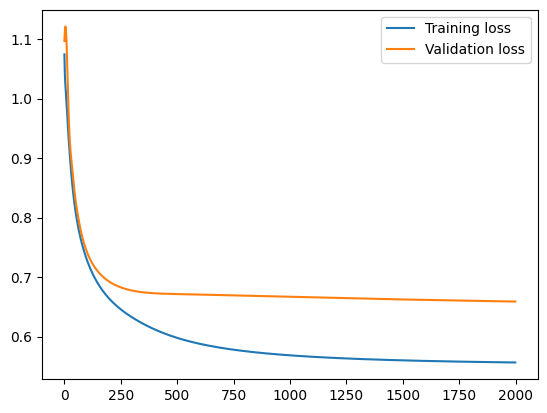

In [43]:
plt.plot(np.arange(0,num_epochs,1), result_train_loss, label='Training loss')
plt.plot(np.arange(0,num_epochs,1), result_test_loss, label='Validation loss')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">
Nous observons une convergence des loss lors de l'entraînement de notre modèle. Cependant, à partir d'un certain nombre d'époques, un écart constant apparaît, indiquant un phénomène de surapprentissage (overfitting). Pour évaluer l'impact de ce surapprentissage, nous allons regardons l'accuracy du modèle sur notre jeu de test. Cette analyse nous permet de déterminer si le modèle, en s'adaptant trop étroitement aux données d'entraînement, voit sa capacité à généraliser sur des données nouvelles et non vues diminuer.
</div>

**Question 3 :** Compute the accuracy.

In [44]:
model.eval()
    
correct = 0 
total = X_test.shape[0]  
 
with torch.no_grad():
    for i in range(X_test.shape[0]):
        y_pred = model(X_test[i])
        if np.argmax(y_pred) == np.argmax(y_test[i]) : 
            correct += 1

print(f'Prédictions correctes : {correct}')
print(f'Taille de l\'échantillon de validation: {total}')  

accuracy = correct / total
print(f'Accuracy sur le jeu de validation: {accuracy:.2f}')

Prédictions correctes : 16
Taille de l'échantillon de validation: 17
Accuracy sur le jeu de validation: 0.94


<div class="alert alert-block alert-warning">
Nous évaluons actuellement l'accuracy de notre modèle sur le jeu de validation. Sur un échantillon de validation de taille 17, notre modèle prédit correctement 16 cas, ce qui équivaut à une accuracy de 0.94. Cette mesure met en lumière la performance globale du modèle sur des données non vues, offrant un aperçu crucial de sa capacité à généraliser au-delà de l'ensemble d'entraînement. Par la suite nous allons essayer de réduire l'overfitting par des méthodes de Dropout et de régularisation et regarder si cela impact notre accuracy.
</div>

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [45]:
#Regularized model
class RegularizedModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(80, 3),
            torch.nn.Dropout(p=0.3),           
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, xb):
        return self.network(xb)

In [46]:
# Entrainement du modèle régularisé    
model = RegularizedModel()
num_epochs = 2000

result_test_loss_reg = []
result_train_loss_reg = []

lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr)
loss = torch.nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    model.train()
    train_losses_reg = []
    for i in range(X_train.shape[0]):
        optimizer.zero_grad()  
        pred_train = model(X_train[i])
        l_train = loss(pred_train, y_train[i])  
        l_train.backward()
        optimizer.step()
        train_losses_reg.append(l_train.item())

    model.eval()
    test_losses_reg = []
    for i in range(X_test.shape[0]):
        pred_test = model(X_test[i])
        l_test = loss(pred_test, y_test[i]) 
        test_losses_reg.append(l_test.item())

    result_train_loss_reg.append(torch.tensor(train_losses_reg).mean().item())  
    result_test_loss_reg.append(torch.tensor(test_losses_reg).mean().item())  

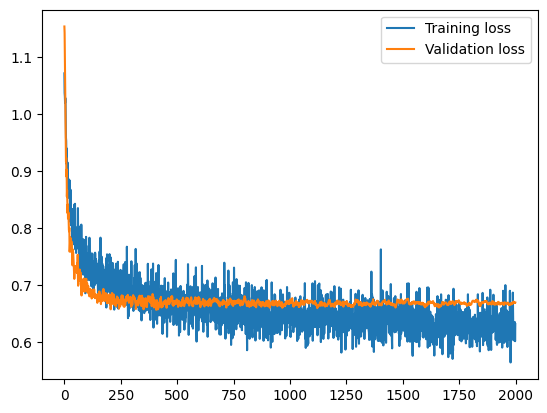

Prédictions correctes : 15
Taille de l'échantillon de validation: 17
Accuracy sur le jeu de validation: 0.88


In [47]:
#Visualisation des résultats
plt.plot(np.arange(0,num_epochs,1), result_train_loss_reg, label='Training loss')
plt.plot(np.arange(0,num_epochs,1), result_test_loss_reg, label='Validation loss')
plt.legend()
plt.show()

#Calcul de l'accuracy
model.eval()
    
correct = 0 
total = X_test.shape[0]  
 
with torch.no_grad():
    for i in range(X_test.shape[0]):
        y_pred = model(X_test[i])
        if np.argmax(y_pred) == np.argmax(y_test[i]) : 
            correct += 1

print(f'Prédictions correctes : {correct}')
print(f'Taille de l\'échantillon de validation: {total}')  

accuracy = correct / total
print(f'Accuracy sur le jeu de validation: {accuracy:.2f}')

<div class="alert alert-block alert-warning">
Nous constatons actuellement que le phénomène d'overfitting n'est plus présent, bien que l'accuracy de notre modèle soit légèrement inférieure. Ces observations suggèrent que l'utilisation du dropout n'apporte pas significativement de stabilité et a un impact mineur sur notre modèle. Par conséquent, il peut ne pas être nécessaire dans ce contexte. Il est possible qu'une augmentation de la taille de l'échantillon de données puisse améliorer la performance du modèle, étant donné que l'échantillon actuel est relativement petit. Cependant, étant donné que l'overfitting n'est plus un problème majeur et que l'accuracy est déjà considérée comme très bonne (0.88), il semble qu'il n'y ait pas grand-chose à gagner en poursuivant d'autres optimisations.
</div>


**Question 5 (Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing

In [48]:
import torch
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=33)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

(54, 18522)


In [49]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Conv1d(in_channels=1,out_channels=3, kernel_size=3, stride=3),  
        torch.nn.MaxPool1d(2),
        torch.nn.Conv1d(in_channels=3,out_channels=1, kernel_size=3, stride=3),
        torch.nn.MaxPool1d(2),
        torch.nn.Linear(18522//(3*2*3*2), 3),     
        torch.nn.Softmax(dim=-1)     
        )

    def forward(self, x):
        return self.network(x)

In [50]:
model = SimpleCNN()
num_epochs = 2000

result_test_loss = []
result_train_loss=[]


lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = torch.nn.CrossEntropyLoss() #Classification problem

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    train_acc = []
    for i in range(X_train.shape[0]):
       # Compute loss
        pred_train = model(X_train[i])
        l_train = loss(pred_train, y_train[i])
        # Optimization step
        l_train.backward()
        # optimizer.step()
        # Save the loss
        train_losses.append(l_train)
    optimizer.step()
    optimizer.zero_grad()
    
    model.eval()
    test_losses = []
    test_acc = []
    for i in range(X_test.shape[0]):
        # Compute loss
        pred_test = model(X_test[i])
        l_test = loss(pred_test, y_test[i])
        # Save the loss
        test_losses.append(l_test)

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append(torch.stack(test_losses).mean().item())

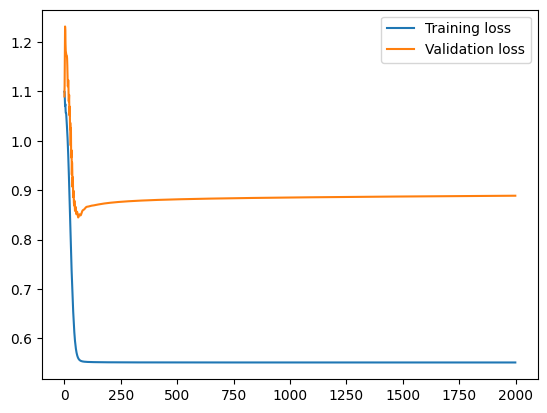

Prédictions correctes : 12
Taille de l'échantillon de validation: 17
Accuracy sur le jeu de validation: 0.71


In [51]:
#Visualisation des résultats
plt.plot(np.arange(0,num_epochs,1), result_train_loss, label='Training loss')
plt.plot(np.arange(0,num_epochs,1), result_test_loss, label='Validation loss')
plt.legend()
plt.show()

#Calcul de l'accuracy
model.eval()
    
correct = 0 
total = X_test.shape[0]  
 
with torch.no_grad():
    for i in range(X_test.shape[0]):
        y_pred = model(X_test[i])
        if np.argmax(y_pred) == np.argmax(y_test[i]) : 
            correct += 1

print(f'Prédictions correctes : {correct}')
print(f'Taille de l\'échantillon de validation: {total}')  

accuracy = correct / total
print(f'Accuracy sur le jeu de validation: {accuracy:.2f}')

<div class="alert alert-block alert-warning">
Dans notre étude comparative, nous observons que le CNN présente des performances similaires au réseau de neurones standard en termes de loss sur le jeu de d'entrainement. Malgré la présence d'un phénomène d'overfitting, le CNN affiche une accuracy sur le jeu de validation plus que correcte, voire même bonne. Cette capacité du CNN à généraliser efficacement, même en présence d'overfitting, est mise en évidence par le fait qu'il a réussi à prédire correctement 12 échantillons sur un total de 17 dans notre échantillon de validation, se traduisant par une accuracy de 71%. 
</div>

**Question 6 (Bonus)** : Performing clustering into three classes. Do the clusters correspond to word classes or male-female?

In [52]:
from sklearn.cluster import KMeans

scaled=StandardScaler()
x_scaled=scaled.fit_transform(X)
pstft = STFT(stat=np.max, idx_frequence_max=80)
x_chap  = np.abs(pstft.transform(x_scaled))

kmeans = KMeans(n_init='auto', init='k-means++',n_clusters=3,random_state=42)
clustering = kmeans.fit(x_chap)
clusters=clustering.labels_

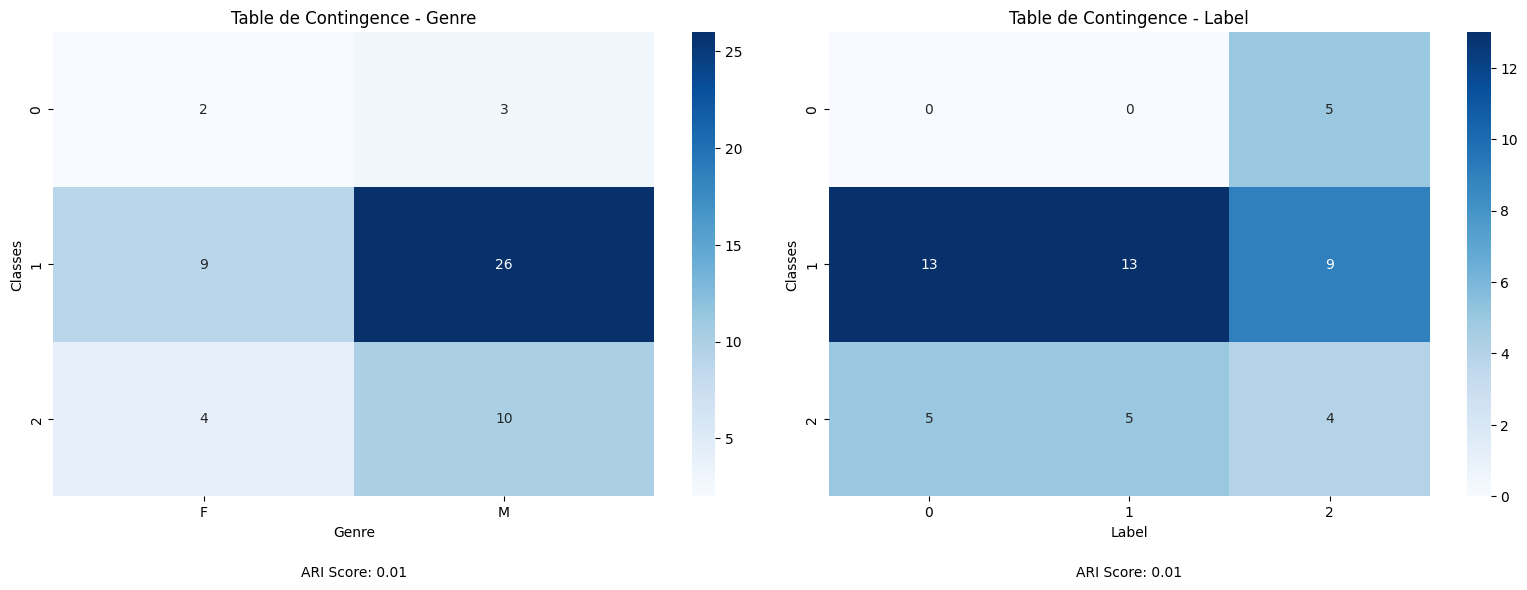

In [53]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score

df = pd.DataFrame(columns=['gender','label','cluster'])
df['gender']=genres
df['label']=label
df['cluster']=clusters

contingency_table1 = pd.crosstab(df['cluster'], df['gender'])
ari_score1 = adjusted_rand_score(df['cluster'], df['gender'])

ari_score2 = adjusted_rand_score(df['cluster'], df['label'])
contingency_table2 = pd.crosstab(df['cluster'], df['label'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

sns.heatmap(contingency_table1, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax1)
ax1.set_title('Table de Contingence - Genre')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Classes')
ax1.text(0.5, -0.15, f'ARI Score: {ari_score1:.2f}', transform=ax1.transAxes, ha='center', va='top')


sns.heatmap(contingency_table2, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax2)
ax2.set_title('Table de Contingence - Label')
ax2.set_xlabel('Label')
ax2.set_ylabel('Classes')
ax2.text(0.5, -0.15, f'ARI Score: {ari_score2:.2f}', transform=ax2.transAxes, ha='center', va='top')


plt.tight_layout()
plt.show()

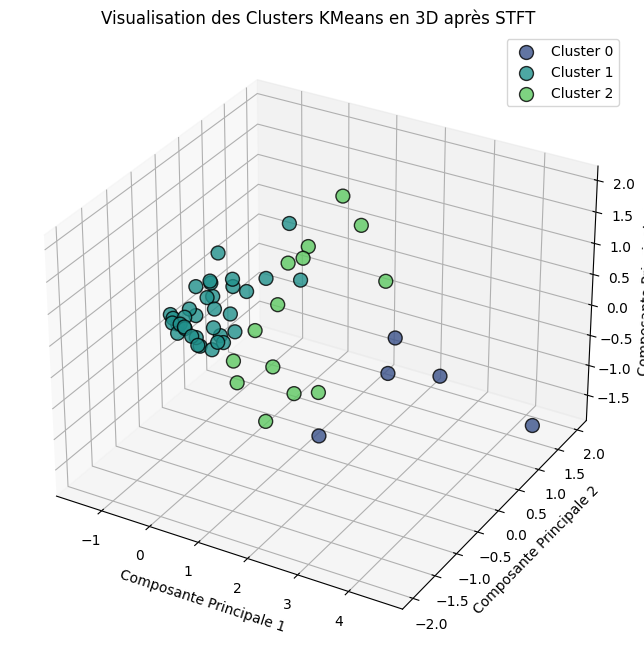

In [54]:
pca_3d = PCA(n_components=3)
x_pca_3d = pca_3d.fit_transform(x_chap)

# Visualisation des clusters en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Définir les couleurs pour les clusters
colors = sns.color_palette('viridis', n_colors=len(np.unique(clusters)))

# Scatter plot avec les couleurs des clusters
for cluster_id in np.unique(clusters):
    ax.scatter(
        x_pca_3d[clusters == cluster_id, 0], 
        x_pca_3d[clusters == cluster_id, 1], 
        x_pca_3d[clusters == cluster_id, 2], 
        color=colors[cluster_id], 
        label=f'Cluster {cluster_id}', 
        s=100, 
        alpha=0.8, 
        edgecolor='k'
    )


# Titre et labels
ax.set_title('Visualisation des Clusters KMeans en 3D après STFT')
ax.set_xlabel('Composante Principale 1')
ax.set_ylabel('Composante Principale 2')
ax.set_zlabel('Composante Principale 3')

# Légende
ax.legend()
plt.show()

<div class="alert alert-block alert-warning">
Nous effectuons un clustering avec un K-means de trois classes. Nous comparons ensuite les résultats avec le genre des personnes et les mots qu'elles utilisent. Cependant, dans les deux cas, nous ne trouvons aucune correspondance entre le clustering obtenu et ces deux critères. C'est la matrice de confusion et l'adjusted Rand Index qui nous permettent de tirer cette conclusion.
</div>

# Conclusion

<div class="alert alert-block alert-warning">

#### Récapitulatif :

Dans ce projet, nous avons effectué un prétraitement des données utilisant la PCA (Analyse en Composantes Principales) et la STFT (Transformée de Fourier à Court Terme) avec des statistiques comme le maximum, le minimum et la moyenne. Après une comparaison des performances sur une régression logistique, nous avons choisi d'utiliser la STFT avec la statistique du maximum. Les résultats ont été analysés à l'aide de matrices de confusion pour mieux comprendre les performances des modèles.

Nous avons exploré différentes méthodes pour le traitement et l'analyse des données :

- Régression Logistique : Utilisée comme méthode de base pour la comparaison des performances.
- Méthodes à Noyau : Nous avons utilisé des SVM (Machines à Vecteurs de Support) avec des noyaux linéaires, RBF (Radial Basis Function) et polynomiaux, avec visualisation des résultats.
- Méthodes d'Assemblage : Nous avons appliqué le bagging, les forêts aléatoires (random forest) et l'adaboost, comparant les performances de ces approches.
- Réseaux de Neurones : Conception de différents modèles de réseaux de neurones, entraînement et analyse des performances.

#### Analyse des résultats :

Nous avons observé que le nombre de données disponibles était limité, ce qui a conduit à des résultats très variables et à l'absence de conclusions claires. Les fluctuations des performances montrent l'importance d'une quantité suffisante de données pour des résultats fiables et consistants.

#### Pour aller plus loin :

Afin de prolonger l'étude, nous avons expérimenté un réseau de neurones convolutionnel (CNN) et un clustering par KMeans. Ces approches ont apporté des perspectives supplémentaires, mais les conclusions restent limitées par le faible volume de données.

Il serait intéressant de refaire ce projet avec un volume de données plus important pour obtenir des résultats plus précis et fiables. Malgré ces limitations, ce projet nous a permis de comparer diverses méthodes vues en cours de Machine Learning, enrichissant notre compréhension des différentes approches et de leurs applications.
</div>